In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
#Task 1.1
boston = fetch_openml(name="boston", version=1, as_frame=True) 
df = boston.frame 
df = df.astype(float) 

X = df.drop('MEDV', axis=1) 
y = df['MEDV'] 

#split para 80%training tapos 20% ung test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training-only dataframe para alang "data leak"
train_df = pd.concat([X_train, y_train], axis=1)

print(train_df.head()) 
print(train_df.describe()) 

         CRIM    ZN  INDUS  CHAS     NOX     RM   AGE     DIS   RAD    TAX  \
477  15.02340   0.0  18.10   0.0  0.6140  5.304  97.3  2.1007  24.0  666.0   
15    0.62739   0.0   8.14   0.0  0.5380  5.834  56.5  4.4986   4.0  307.0   
332   0.03466  35.0   6.06   0.0  0.4379  6.031  23.3  6.6407   1.0  304.0   
423   7.05042   0.0  18.10   0.0  0.6140  6.103  85.1  2.0218  24.0  666.0   
19    0.72580   0.0   8.14   0.0  0.5380  5.727  69.5  3.7965   4.0  307.0   

     PTRATIO       B  LSTAT  MEDV  
477     20.2  349.48  24.91  12.0  
15      21.0  395.62   8.47  19.9  
332     16.9  362.25   7.83  19.4  
423     20.2    2.52  23.29  13.4  
19      21.0  390.95  11.28  18.2  
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.609125   11.569307   10.985050    0.071782    0.556484    6.315891   
std      8.875058   23.152481    6.894618    0.258447    0.117704    0.7

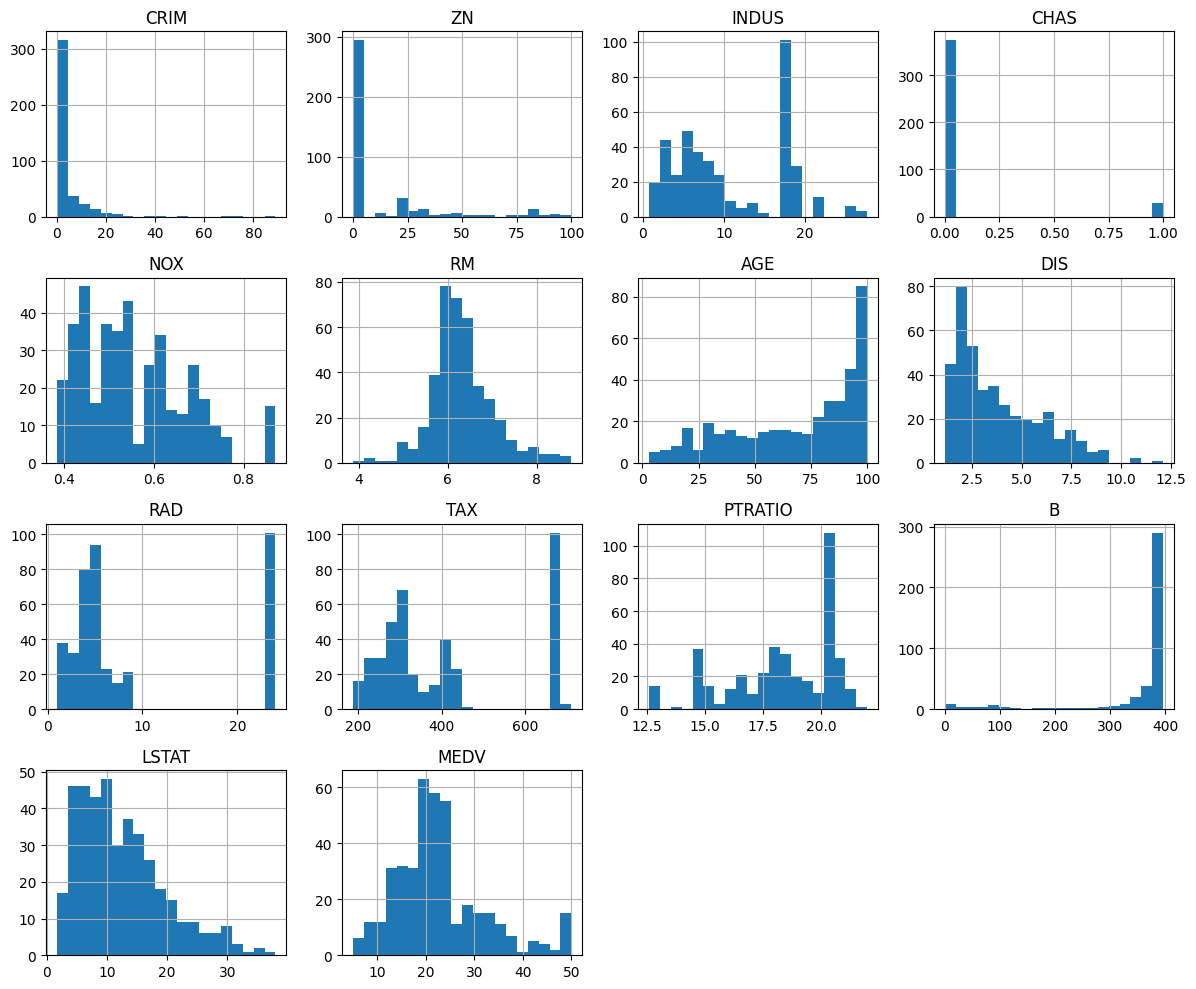

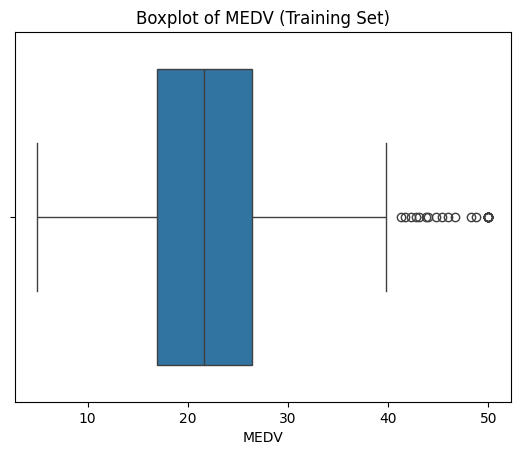

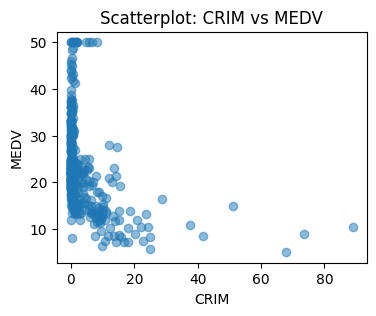

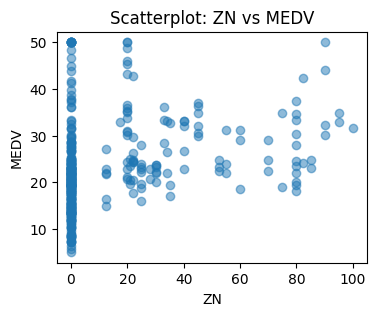

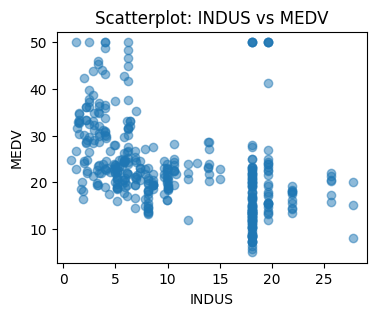

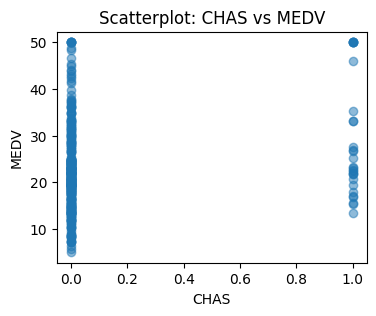

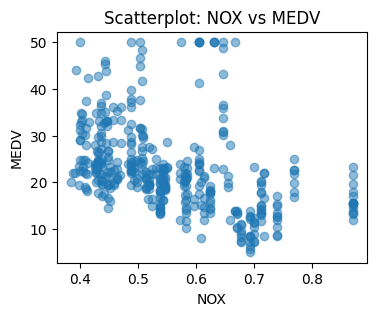

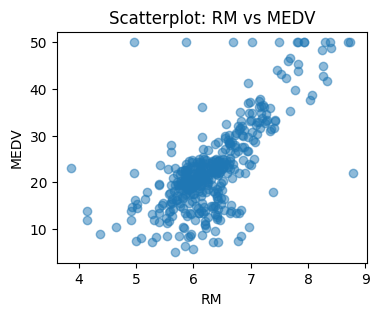

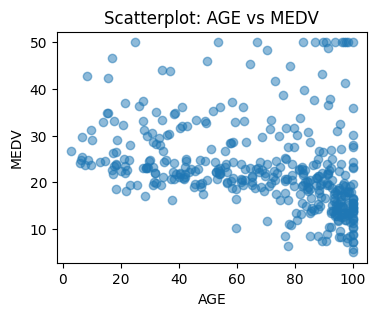

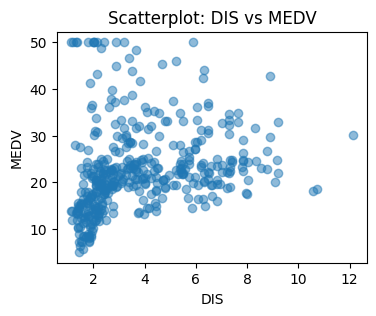

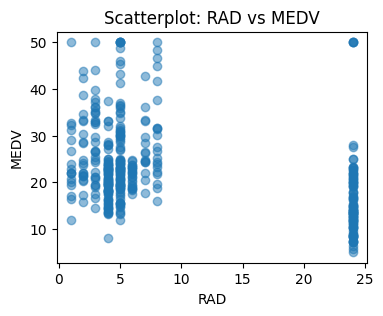

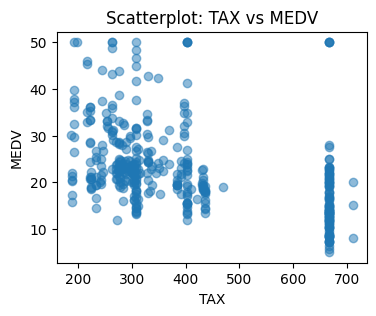

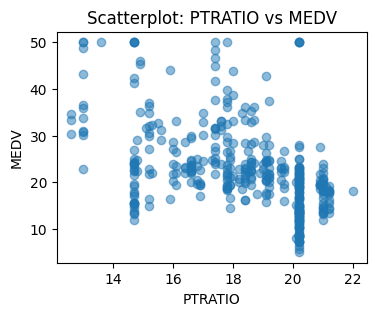

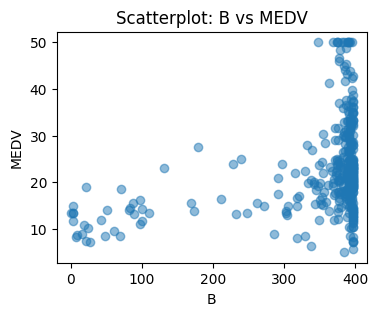

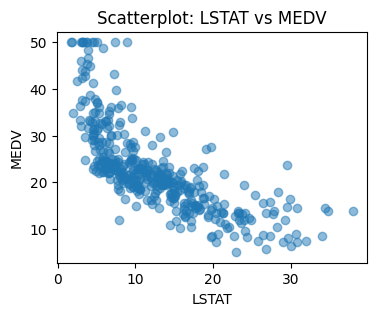

In [10]:
#Task 1.2 & 1.3
# Note: The target variable (MEDV) is censored at 50, which violates linearity and normality assumptions
train_df.hist(figsize=(12, 10), bins=20) 
plt.tight_layout()
plt.show()

sns.boxplot(x=train_df['MEDV']) 
plt.title('Boxplot of MEDV (Training Set)')
plt.show()

for col in X_train.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(train_df[col], train_df['MEDV'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('MEDV')
    #ginawa kong mumeric ung rad kasi taena eh 
    plt.title(f'Scatterplot: {col} vs MEDV')
    plt.show()

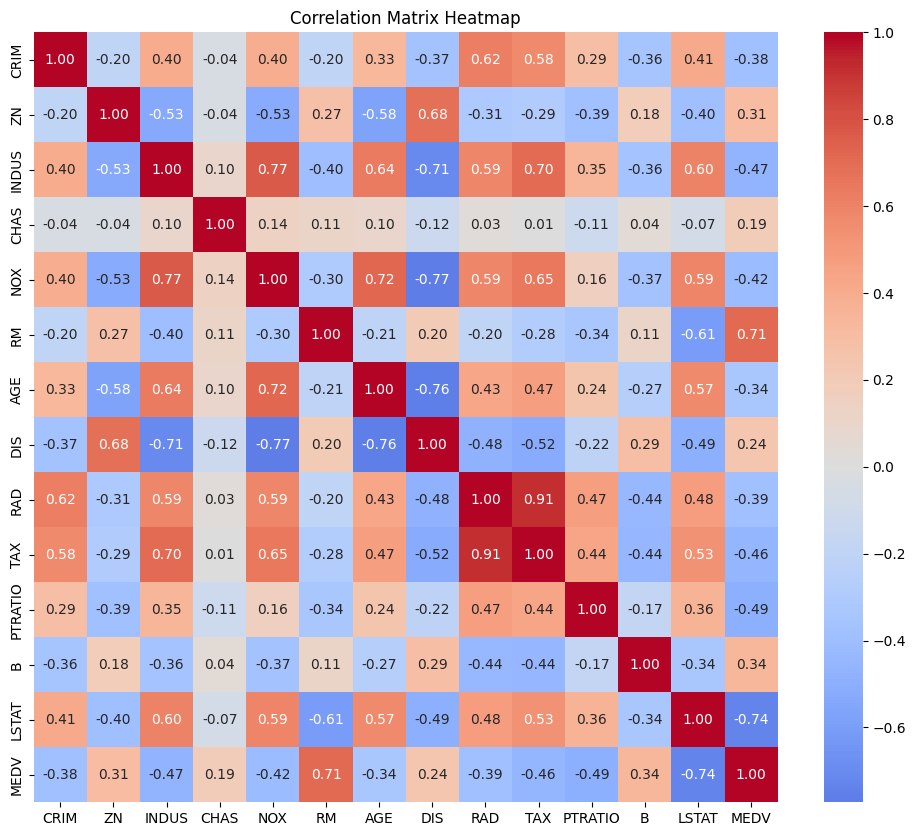

In [11]:
#Task 2.1
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [12]:
# Task 3.1
X_train_const = sm.add_constant(X_train).astype(float) 
model_full = sm.OLS(y_train, X_train_const).fit() 
print(model_full.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Tue, 03 Feb 2026   Prob (F-statistic):          6.21e-109
Time:                        17:25:34   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2468      5.677      5.328      0.0

In [13]:
# Task 3.2
X_test_const = sm.add_constant(X_test).astype(float)
y_pred = model_full.predict(X_test_const)
print(f"Test R-squared: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

Test R-squared: 0.6688
Test RMSE: 4.9286


In [14]:
# Task 4.1:
fitted_vals = model_full.fittedvalues 
residuals = model_full.resid 

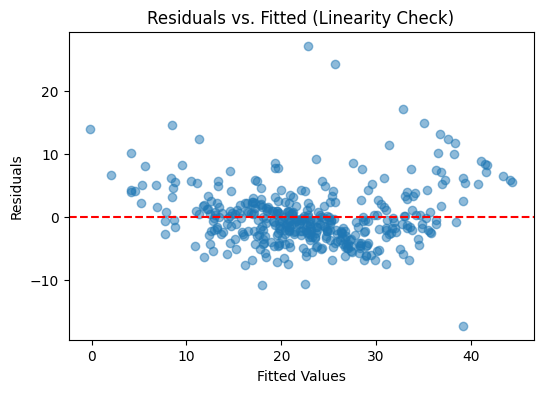

In [15]:
# 1. Linearity: Residuals vs. Fitted plot
plt.figure(figsize=(6,4)) #pang estekik lang
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Linearity Check)') 
plt.show()

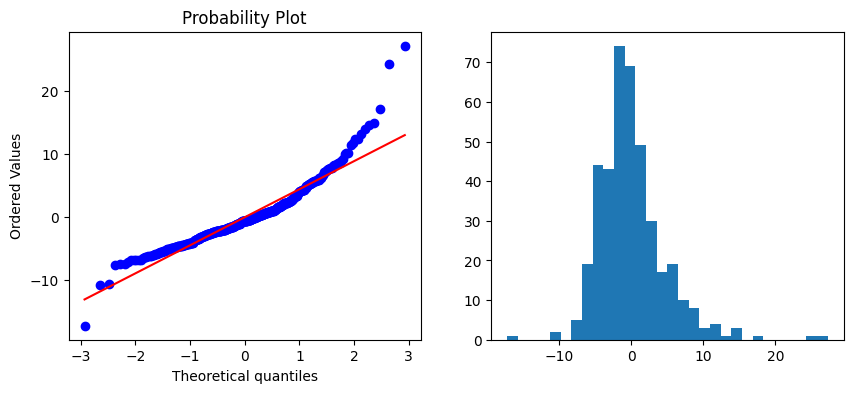

Shapiro-Wilk Test p-value: 1.3222205573679593e-14


In [16]:
# 2. Normality: Q-Q Plot and Histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(residuals, dist="norm", plot=ax1) 
ax2.hist(residuals, bins=30) 
plt.show()
print(f"Shapiro-Wilk Test p-value: {stats.shapiro(residuals).pvalue}") 

In [17]:
# 3. Homoscedasticity: Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model_full.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}") 

Breusch-Pagan p-value: 7.332519419035671e-08


In [18]:
#Task 5.1: Calculate VIF
X_vif = sm.add_constant(X_train).astype(float)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Aesthetic shits to to Drop the constant row para sa final report 
vif_data = vif_data[vif_data['feature'] != 'const']
print(vif_data)

    feature       VIF
1      CRIM  1.713187
2        ZN  2.465631
3     INDUS  3.877855
4      CHAS  1.096674
5       NOX  4.469150
6        RM  1.947809
7       AGE  2.989948
8       DIS  4.168578
9       RAD  7.658316
10      TAX  8.943301
11  PTRATIO  1.851448
12        B  1.325121
13    LSTAT  2.818045


wait di pa ako sure double check ko final answer sa iba bukas